<a href="https://colab.research.google.com/github/vijishmadhavan/Crop-CLIP/blob/master/Crop_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install requirements
%%capture
!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install ipyplot

In [ ]:
#@title import
import glob
import pprint as pp
import time
from re import T
from urllib.parse import parse_qs, urlparse
import clip
import numpy as np
import requests
import torch
from PIL import Image
import io



Type in a url to a direct link of an **image**.

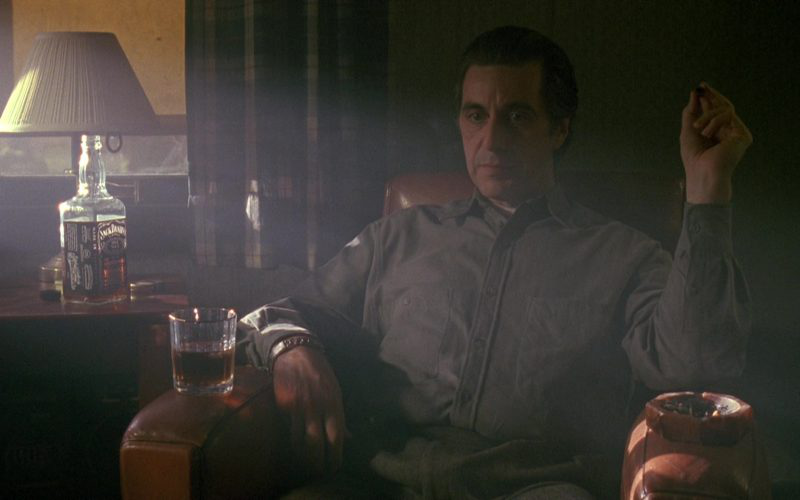

In [ ]:
url = 'https://productplacementblog.com/wp-content/uploads/2018/02/Jack-Daniels-and-Al-Pacino-in-Scent-of-a-Woman-12-800x500.jpg' #@param {type:"string"}
import requests
from PIL import Image
from io import BytesIO
import warnings
import uuid
warnings.filterwarnings("ignore")
import tempfile

response = requests.get(url)
img1 = Image.open(BytesIO(response.content)).convert("RGB")
img1


In [ ]:
#@title yolo
from IPython.display import Image, display
from PIL import Image, ImageFont
import os
import cv2
import torch
import glob
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

results = model(img1)  # includes NMS
#image_path = "/content/"
#os.mkdir(image_path)
#image = results.save("/content/image")
dirpath = tempfile.mkdtemp()
results.crop(save_dir=dirpath)
from IPython.display import Image
#Image(filename='/content/image/image0.jpg')
path= dirpath+'/crops/**/*.jpg'

txtfiles = []

for file in glob.glob(path):
    txtfiles.append(file)

import ipyplot
from PIL import Image

l = []
#keyList = list(range(len(txtfiles)))
for filename in glob.glob(path):
  foo = Image.open(filename).convert('RGB')
  #resized_image = foo.resize((250,250))
  l.append(foo) 

import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

images = torch.stack([preprocess(im) for im in l]).to(device)
with torch.no_grad():
  image_features = model.encode_image(images)
  image_features /= image_features.norm(dim=-1, keepdim=True)

image_features.cpu().numpy()
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

images = [preprocess(im) for im in l]
image_input = torch.tensor(np.stack(images)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
image_features /= image_features.norm(dim=-1, keepdim=True)

def similarity_top(similarity_list,N):
  results = zip(range(len(similarity_list)), similarity_list)
  results = sorted(results, key=lambda x: x[1],reverse= True)
  top_images = []
  scores=[]
  for index,score in results[:N]:
    scores.append(score)
    top_images.append(l[index])
  return scores,top_images

In [ ]:
search_query = "jack daniels"



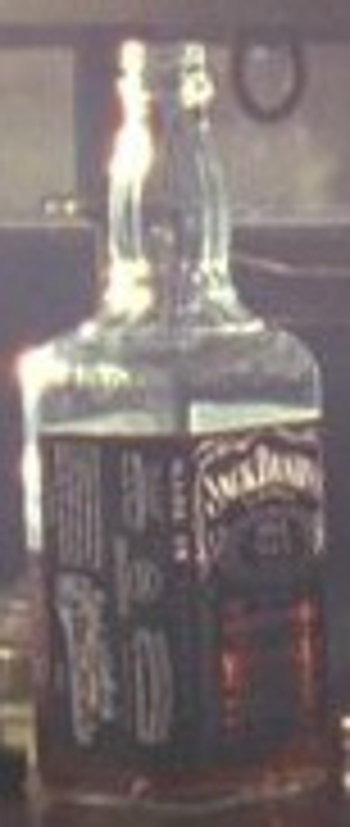


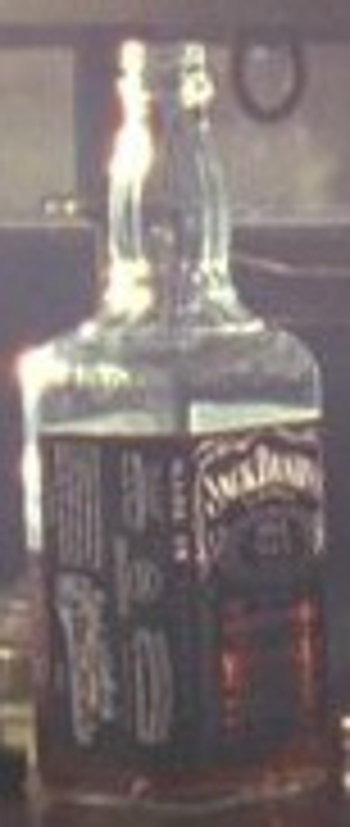

In [ ]:
#@title Crop
with torch.no_grad():
    # Encode and normalize the description using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

# Retrieve the description vector and the photo vectors

similarity = text_encoded.cpu().numpy() @ image_features.cpu().numpy().T
similarity = similarity[0]
scores,imgs= similarity_top(similarity,N=1)
ipyplot.plot_images(imgs,img_width=350)